In [76]:
import torch
from torch import nn
from torchvision.ops.boxes import box_iou, _box_cxcywh_to_xyxy
from PIL import Image, ImageDraw
import numpy as np

In [69]:
a = torch.tensor([
    [
        [1, 10, 10, 10, 10],
        [1, 10, 80, 20, 20],
    ],
    [
        [1, 90, 20, 20, 20],
        [1, 100, 100, 30, 30],
    ]
])
b = torch.tensor([
    [
        [1, 10, 10, 9, 9],
        [1, 13, 78, 18, 25],
    ],
    [
        [1, 87, 23, 22, 25],
        [1, 100, 100, 30, 29],
    ]
])

tensor([[0.0022, 0.0000],
        [0.0267, 0.0989]])


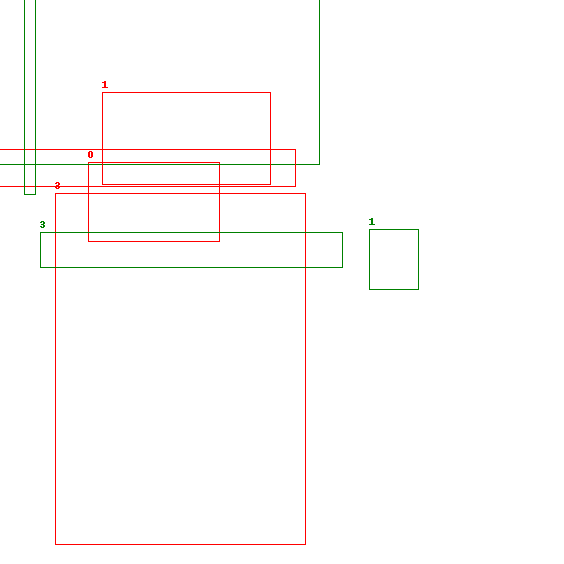

In [113]:
def calculate_ious(predictions, targets):
    r"""
    Função que calcula os ious entre as predições e as targets (anotações).  
    Os tensores vêm no formato [S, S, 5] onde 5-> [p, xc, yc, w, h]

    Args:  
        Predictions -> Tensor que vem no formato [S, S, 5]
        Target -> Tensor que vem no formato [S, S, 5]
    
    Returns: 
        ious -> Tensor no formato [S, S, 1] onde 1 representa o IOU entre as bboxes entre cada casas.
    """
    assert predictions.shape[:2] == targets.shape[:2]
    assert predictions.shape[-1] == targets.shape[-1] == 5

    bbox1 = predictions[..., 1:] # pega somente [xc, yc, w, h] pois vem no formato [p, xc, yc, w, h]
    bbox2 = targets[..., 1:] # o mesmo

    # agora convertendo para [x1, y1, x2, y2]
    bbox1 = _box_cxcywh_to_xyxy(bbox1)
    bbox2 = _box_cxcywh_to_xyxy(bbox2)

    # calculando agora os ious
    ious = box_iou(bbox1.reshape(-1, 4), bbox2.reshape(-1, 4)) # essa função nativa do pytorch só aceita tensores com shape= [N, 4]
    ious = ious.diagonal() # assim pegamos sua diagonal pois queremos somente os elementos comparados na mesma casa
    
    ious = ious.reshape(predictions.shape[:2]) # retorna com o mesmo shape de linhas e colunas S, S e mais uma dimensão com o valor do iou

    return ious

def inspecao_visual_ious(bbox1, bbox2):
    
    bbox1 = bbox1[..., 1:] # pega somente [xc, yc, w, h] pois vem no formato [p, xc, yc, w, h]
    bbox2 = bbox2[..., 1:] # o mesmo

    # agora convertendo para [x1, y1, x2, y2]
    bbox1 = _box_cxcywh_to_xyxy(bbox1)
    bbox2 = _box_cxcywh_to_xyxy(bbox2)

    maximo = int(torch.tensor([bbox1.max(), bbox2.max()]).max())
    img_pil = Image.new('RGB', size=(maximo+20, maximo+20), color='white')
    draw = ImageDraw.Draw(img_pil)

    for k, (box1, box2) in enumerate(zip(bbox1.reshape(-1, 4), bbox2.reshape(-1, 4))):
        box1 = box1.detach().numpy()
        box2 = box2.detach().numpy()

        draw.rectangle(box1, fill=None, outline='red')
        draw.text([box1[0],box1[1]-13], str(k), fill='red')

        draw.rectangle(box2, fill=None, outline='green')
        draw.text([box2[0],box2[1]-13], str(k), fill='green')
    
    return img_pil

a = 10+torch.rand((2, 2, 5))*400
b = 10+torch.rand((2, 2, 5))*400
print (calculate_ious(a, b))
inspecao_visual_ious(a, b)